# De novo design

### Developers: Mat Bieniek, Ben Cree, Rachael Pirie, Josh Horton

* Add R-groups in user-defined positions
* Output ADMET properties
* Perform constrained optimisation
* Score poses
* Send output to free energy calculations

Open source, customisable, fast/easy to use.

In [1]:
import copy
import glob
import prody
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
from rgroup import RMol, RList, build_molecules, fix_receptor, optimise_in_receptor, RGroups, sort_conformers, ic50

<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [41]:
%cd ~/rgroups/dat/tyk2/19jan
%pwd

/home/c0065492/rgroups/dat/tyk2/19jan


'/home/c0065492/rgroups/dat/tyk2/19jan'

In [3]:
prefix = 'lig_ejm_' #to extract experimental data from ligands.yml

In [4]:
!wget -nc https://files.rcsb.org/download/4GIH.pdb
pdb = '4GIH.pdb'

File ‘4GIH.pdb’ already there; not retrieving.



In [5]:
RMol.set_gnina(loc='/home/c0065492/software/gnina')

In [6]:
# load the complex with the ligand
sys = prody.parsePDB(pdb)
#sys = prody.parsePDB('jnk1/2gmx.pdb')

rec = sys.select('not (nucleic or hetatm) and not water')
#mol = sys.select('resname 19H and chain A')
mol = sys.select('resname 0X5')

prody.writePDB('rec.pdb', rec)
#prody.writePDB('lig.pdb', mol)

@> 2477 atoms and 1 coordinate set(s) were parsed in 0.04s.


'rec.pdb'

In [7]:
#!wget 'https://models.rcsb.org/v1/5nev/ligand?auth_seq_id=301&label_asym_id=E&encoding=sdf&filename=5nev_E_72L.sdf' -O lig.sdf
#!obabel jnk1/core.sdf -O jnk1/coreh.sdf -p 7
!obabel -isdf core.sdf -osdf -O coreh.sdf -p 7
# ^manually modify the files if need be
%pwd

1 molecule converted


'/home/c0065492/rgroups/dat/tyk2/tyk2_dat'

In [8]:
# load the ligand
# rdkit doesn't do a good job with protonation, 
#init_mol = Chem.MolFromPDBFile('lig.pdb', removeHs=False)
#init_mol = Chem.AddHs(init_mol, addCoords=True)

init_mol = Chem.SDMolSupplier('coreh.sdf', removeHs=False)[0]

# get the R group representation of the rdkit Mol
rinit_mol = RMol(init_mol)

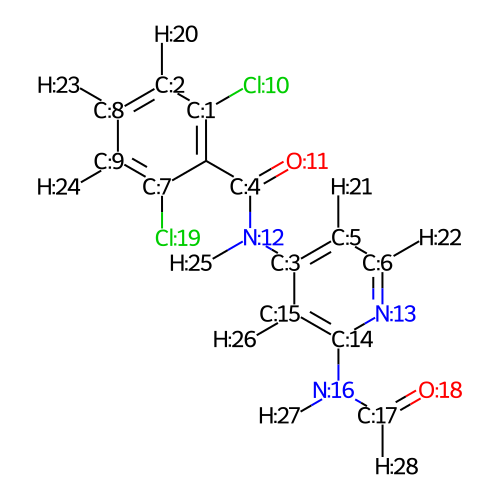

In [9]:
# select the atom to be replaced with the R group
rinit_mol.rep2D(idx=True, size=(500, 500))

In [10]:
#remove 44 since all conformers clash with protein
ligand_ids = [31, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55] # 27, 28, stereochem issues
len(ligand_ids)

12

In [11]:
#ligand_ids = ['13c', '13d', '13h', '17c', '17h']
# read the rgroups 1 by 1 in a loop
# assumes that there is only one -r.mol in each dir
rgroups = [Chem.MolFromMolFile(glob.glob(f'{ligand_id}/*.mol')[0], removeHs=False) for ligand_id in ligand_ids]
rgroups

In [12]:
ligand_ids[0] #to check what rgroup is failing optimisation or clash with protein

31

In [13]:
# build a list of molecules
attachment_index = [28]
rmols = build_molecules(rinit_mol, attachment_index, rgroups)

Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f9c5d0cc3a0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f9c5d0cc2e0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f9c5d0cc520> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f9c5d0cc460>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f9c5d0cc2e0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f9c5d0cc3a0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f9c5d0cc520> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f9c5d0cc460>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f9c5d0cc2e0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f9c5d0cc3a0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f9c5d0cc520> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f9c5d0cc460>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f9c5d0cc2e0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f9c5d0cc3a0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom o

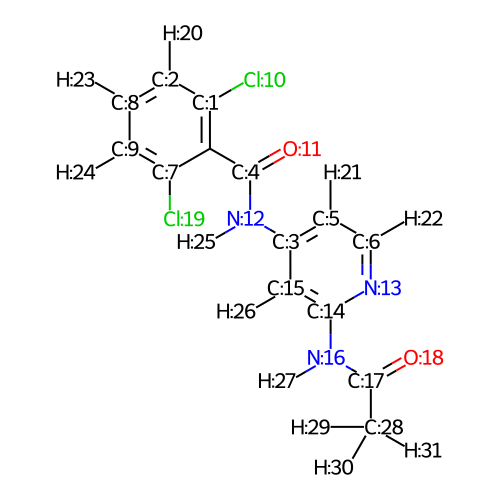

In [14]:
rmols[0].rep2D(idx=True, size=(500, 500))

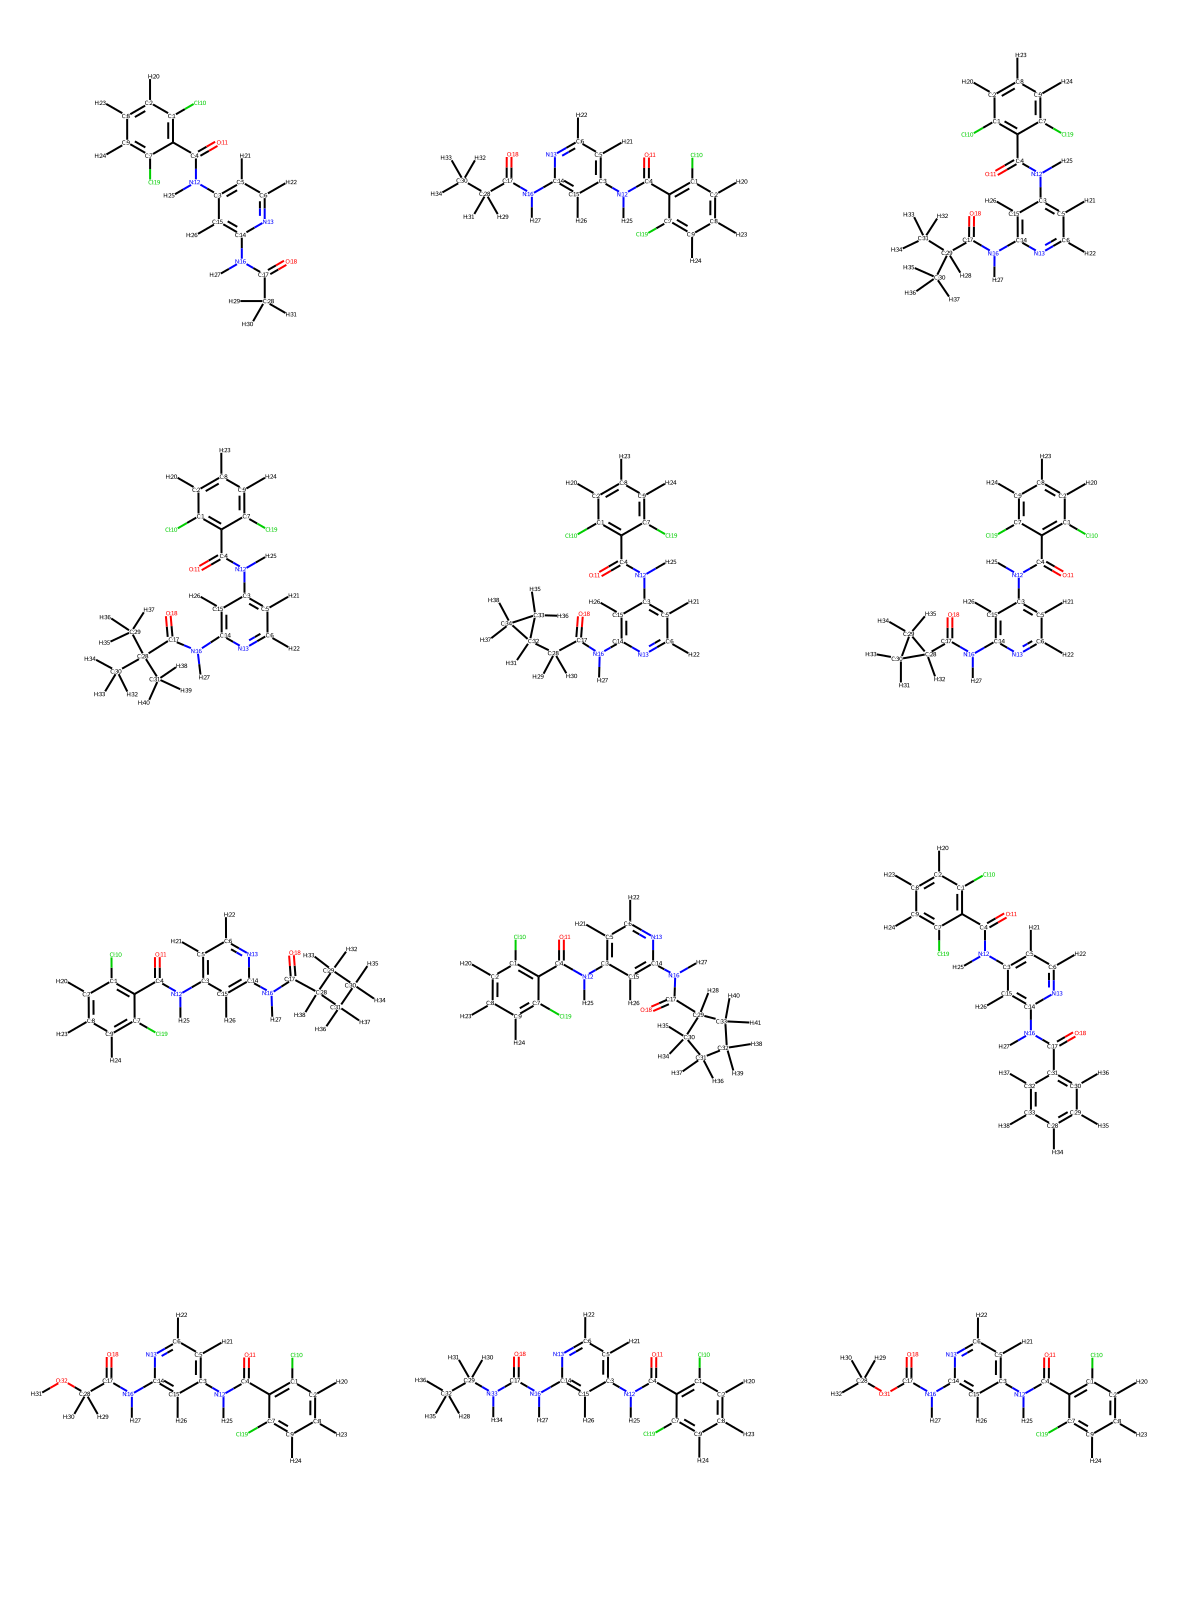

In [15]:
rmols.rep2D()

In [16]:
rmols[3].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [17]:
rmols.toxicity()

,MW,HBA,HBD,LogP,Pass_Ro5,has_pains,has_unwanted_subs,has_prob_fgs,synthetic_accessibility
0,323.022832,3,2,3.5991,True,False,False,False,6.747622
0,337.038482,3,2,3.9892,True,False,False,False,7.010544
0,351.054132,3,2,4.2352,True,False,False,False,7.250500
0,365.069782,3,2,4.6253,True,False,False,False,7.456506
0,363.054132,3,2,4.3793,True,False,False,False,7.269905
0,349.038482,3,2,3.9892,True,False,False,False,7.031819
0,363.054132,3,2,4.3793,True,False,False,False,7.305428
0,377.069782,3,2,4.7694,True,False,False,False,7.523953
0,385.038482,3,2,4.8930,True,False,False,False,6.985585
0,339.017747,4,3,2.5715,True,False,False,False,6.801717


In [18]:
rmols.generate_conformers(num_conf=200,
                         minimum_conf_rms=0.5,
                         #flexible = [16, 17, 18, 27]
                         )

RMol index 0
removed 198 duplicated conformations
RMol index 1
removed 190 duplicated conformations
RMol index 2
removed 165 duplicated conformations
RMol index 3
removed 104 duplicated conformations
RMol index 4
removed 172 duplicated conformations
RMol index 5
removed 186 duplicated conformations
RMol index 6
removed 177 duplicated conformations
RMol index 7
removed 163 duplicated conformations
RMol index 8
removed 197 duplicated conformations
RMol index 9
removed 194 duplicated conformations
RMol index 10
removed 182 duplicated conformations
RMol index 11
removed 197 duplicated conformations


In [19]:
#rmol.rep3D(template=True)

In [20]:
rmols.GetNumConformers()

[3, 11, 36, 97, 29, 15, 24, 38, 4, 7, 19, 4]

### Optimise conformers in context of protein

In [21]:
# fix the receptor file 
fix_receptor("rec.pdb", "rec_h.pdb")
# load back into prody
rec_fix = prody.parsePDB("rec_h.pdb")

@> 4643 atoms and 1 coordinate set(s) were parsed in 0.03s.


In [22]:
# filter by the protein clashes
rmols[2].rep3D(prody=rec_fix)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [23]:
rmols.removeConfsClashingWithProdyProt(rec_fix)

RMol index 0
RMol index 1
Clash with the protein. Removing conformer id: 6
Clash with the protein. Removing conformer id: 2
Clash with the protein. Removing conformer id: 1
RMol index 2
Clash with the protein. Removing conformer id: 35
Clash with the protein. Removing conformer id: 34
Clash with the protein. Removing conformer id: 31
Clash with the protein. Removing conformer id: 30
Clash with the protein. Removing conformer id: 29
Clash with the protein. Removing conformer id: 28
Clash with the protein. Removing conformer id: 27
Clash with the protein. Removing conformer id: 26
Clash with the protein. Removing conformer id: 24
Clash with the protein. Removing conformer id: 23
Clash with the protein. Removing conformer id: 22
Clash with the protein. Removing conformer id: 18
Clash with the protein. Removing conformer id: 11
Clash with the protein. Removing conformer id: 8
Clash with the protein. Removing conformer id: 3
Clash with the protein. Removing conformer id: 1
RMol index 3
Clas

In [24]:
rmols.GetNumConformers()

[3, 8, 20, 1, 3, 7, 12, 26, 1, 5, 19, 4]

In [25]:
rmols[2].rep3D(prody=rec_fix)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [26]:
# opt_mol, energies
energies = rmols.optimise_in_receptor(
    receptor_file="rec_h.pdb", 
    ligand_force_field="openff", 
    use_ani=True,
    sigma_scale_factor=0.8,
    relative_permittivity=4
)

RMol index 0


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 8)
 - Atom C (index 13)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 8)
 - Atom C (index 13)



using ani2x


Optimising conformer: 100%|███████████████████████| 3/3 [00:10<00:00,  3.65s/it]


RMol index 1


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 8)
 - Atom C (index 13)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 8)
 - Atom C (index 13)



using ani2x


Optimising conformer: 100%|███████████████████████| 8/8 [00:27<00:00,  3.39s/it]


RMol index 2


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 8)
 - Atom C (index 13)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 8)
 - Atom C (index 13)



using ani2x


Optimising conformer: 100%|█████████████████████| 20/20 [01:15<00:00,  3.78s/it]


RMol index 3


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 8)
 - Atom C (index 13)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 8)
 - Atom C (index 13)



using ani2x


Optimising conformer: 100%|███████████████████████| 1/1 [00:06<00:00,  6.97s/it]


RMol index 4


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 8)
 - Atom C (index 13)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 8)
 - Atom C (index 13)



using ani2x


Optimising conformer: 100%|███████████████████████| 3/3 [00:10<00:00,  3.65s/it]


RMol index 5


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 8)
 - Atom C (index 13)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 8)
 - Atom C (index 13)



using ani2x


Optimising conformer: 100%|███████████████████████| 7/7 [00:26<00:00,  3.72s/it]


RMol index 6


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 8)
 - Atom C (index 13)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 8)
 - Atom C (index 13)



using ani2x


Optimising conformer: 100%|█████████████████████| 12/12 [00:55<00:00,  4.66s/it]


RMol index 7


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 8)
 - Atom C (index 13)



using ani2x


Optimising conformer: 100%|█████████████████████| 26/26 [01:23<00:00,  3.20s/it]


RMol index 8


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 8)
 - Atom C (index 13)



using ani2x


Optimising conformer: 100%|███████████████████████| 1/1 [00:05<00:00,  5.81s/it]


RMol index 9


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 8)
 - Atom C (index 13)



using ani2x


Optimising conformer: 100%|███████████████████████| 5/5 [00:16<00:00,  3.22s/it]


RMol index 10


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 8)
 - Atom C (index 13)



using ani2x


Optimising conformer: 100%|█████████████████████| 19/19 [01:12<00:00,  3.83s/it]


RMol index 11


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 8)
 - Atom C (index 13)



using ani2x


Optimising conformer: 100%|███████████████████████| 4/4 [00:11<00:00,  2.87s/it]


In [27]:
rmols[0].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [28]:
for i in range(len(ligand_ids)):
    rmols[i].to_file("optimised_coords_" + str(ligand_ids[i]) + ".pdb")

In [29]:
final_energies = rmols.sort_conformers(energy_range=5)

RMol index 0
RMol index 1
RMol index 2
RMol index 3
RMol index 4
RMol index 5
RMol index 6
RMol index 7
RMol index 8
RMol index 9
RMol index 10
RMol index 11


In [30]:
len(ligand_ids) == len(rmols) #check theyre equal or very bad and silent things happen

True

In [31]:
rmols.discard_missing()

[]

In [32]:
for i in range(len(ligand_ids)):
    rmols[i].to_file("best_conformers_" + str(ligand_ids[i]) + ".pdb")

In [33]:
ligand_id_idx = [5, 4]

In [34]:
CNNscores = rmols.gnina(receptor_file="rec_h.pdb") 

RMol index 0
RMol index 1
RMol index 2
RMol index 3
RMol index 4
RMol index 5
RMol index 6
RMol index 7
RMol index 8
RMol index 9
RMol index 10
RMol index 11


In [40]:
import dill
dill.dump_session('notebook_tyk2_21jan.db')

In [36]:
ic50_scores = []
for i in range(len(CNNscores)):
    ic50_scores.append([ic50(x) for x in CNNscores[i]])

In [37]:
for i in range(len(ic50_scores)):
    with open('scores_' + str(ligand_ids[i]) + '.dat', 'w') as f:
        for x in range(len(ic50_scores[i])):
            f.write(str(ic50_scores[i][x])+'\n')

In [38]:
lowest = []
for i in range(len(ic50_scores)):
    lowest.append(ic50_scores[i][0])

In [42]:
import yaml
with open("ligands.yml", "r") as stream:
    try:
        data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
suffix = ''
experimental = []
for i in range(len(ligand_ids)):
    if data[prefix + str(ligand_ids[i])+suffix]['measurement']['unit'] == 'nM':
        print('found nM')
        experimental.append(data[prefix+ str(ligand_ids[i])+suffix]['measurement']['value'])
    elif data[prefix + str(ligand_ids[i])+suffix]['measurement']['unit'] == 'uM':
        experimental.append(1000*data[prefix+ str(ligand_ids[i])+suffix]['measurement']['value'])
    else:
        print('UNKNOWN UNIT - SKIPPING')
experimental 

[96.0, 64.0, 840.0, 3500.0, 94.0, 4.8, 74.0, 240.0, 2000.0, 250.0, 18.0, 170.0]

In [43]:
import pandas as pd

name = [ligand_ids[i:i+1] for i in range(0, len(ligand_ids), 1)]
energies = [i[0] for i in final_energies]
cnn = [i[0] for i in CNNscores]
ic50 = [i[0] for i in ic50_scores]
expt = [i for i in experimental]
output = pd.DataFrame({'ID' : name, 'Final energies' : energies, 'Gnina score' : cnn, 'Gnina IC50 / nM' : ic50, 'Experimental IC50 / nM' : expt})
output

,ID,Final energies,Gnina score,Gnina IC50 / nM,Experimental IC50 / nM
0,[31],0.0,6.90273,125.103656,96.0
1,[42],0.0,7.06791,85.524393,64.0
2,[43],0.0,7.08674,81.895493,840.0
3,[44],0.0,6.96764,107.735790,3500.0
4,[45],0.0,7.30826,49.174505,94.0
5,[46],0.0,7.23208,58.603020,4.8
6,[47],0.0,7.29632,50.545209,74.0
7,[48],0.0,7.32196,47.647487,240.0
8,[49],0.0,6.82116,150.952392,2000.0
9,[50],0.0,6.68264,207.663419,250.0


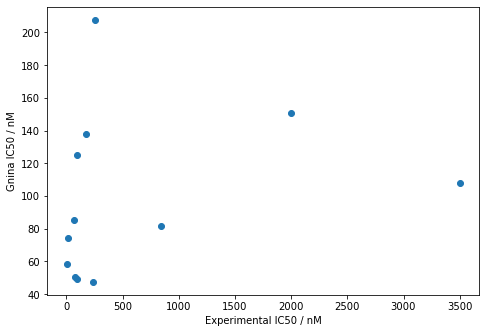

In [44]:
import matplotlib.pyplot as plt
import numpy as np
#ligands 27 & 28 have stereochem issues
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(experimental, lowest) #, color='black', marker='x')
ax.set_xlabel('Experimental IC50 / nM')
ax.set_ylabel('Gnina IC50 / nM')

x = np.linspace(0,25,25)
y = np.linspace(50,350,25)
#ax.plot(x, y, color='black', linestyle='--')

plt.savefig('out.png', bbox_inches='tight')
plt.show()

In [45]:
ligand_ids

[31, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55]

In [46]:
import re
smina_affinities = []
with open('smina_scores.dat', 'r') as f:
    for line in f:
        affinity = re.findall(r'Affinity: (-?\d+.\d+)', str(line))
        try:
            smina_affinities.append(float(affinity[0]))
        except:
            pass

In [47]:
filtered_ids = copy.copy(ligand_ids)
for i in range(len(ligand_id_idx)):
    filtered_ids.remove(ligand_ids[ligand_id_idx[i]])
filtered_ids

[31, 42, 43, 44, 47, 48, 49, 50, 54, 55]

In [48]:
import yaml
with open("ligands.yml", "r") as stream:
    try:
        data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
suffix = ''
experimental_filtered = []
for i in range(len(filtered_ids)):
    if data[prefix + str(filtered_ids[i])+suffix]['measurement']['unit'] == 'nM':
        print('found nM')
        experimental_filtered.append(data[prefix+ str(lfiltered_ids[i])+suffix]['measurement']['value'])
    elif data[prefix + str(filtered_ids[i])+suffix]['measurement']['unit'] == 'uM':
        print('found uM')
        experimental_filtered.append(1000*data[prefix+ str(filtered_ids[i])+suffix]['measurement']['value'])
    else:
        print('UNKNOWN UNIT - SKIPPING')
experimental_filtered

found uM
found uM
found uM
found uM
found uM
found uM
found uM
found uM
found uM
found uM


[96.0, 64.0, 840.0, 3500.0, 74.0, 240.0, 2000.0, 250.0, 18.0, 170.0]

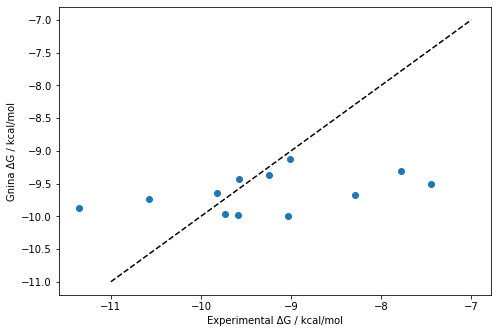

In [52]:
import matplotlib.pyplot as plt
import numpy as np
# convert nM to M
exptinM = [ i * 1e-9 for i in experimental]
lowestinM = [i * 1e-9 for i in lowest]
RT = 0.593 # kcal/mol

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

# DG = RTln(K)
ax.scatter(RT*np.log(exptinM), RT*np.log(lowestinM)) #, color='black', marker='x')
ax.set_xlabel('Experimental \u0394G / kcal/mol')
ax.set_ylabel('Gnina \u0394G / kcal/mol')

x = np.linspace(-11,-7,10)
ax.plot(x, x, color='black', linestyle='--')
A = np.vstack([experimental_filtered, np.ones(len(experimental_filtered))]).T
#m, c = np.linalg.lstsq(A, lowest, rcond=None)[0]

#m = "{:.2f}".format(m)
#r = "r^2 =" + str(m)
#plt.annotate(r, (-10,-6))
plt.savefig('deltaG2.png', bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# convert nM to M
exptinM = [ i * 1e-9 for i in experimental]

RT = 0.593 # kcal/mol

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

# DG = RTln(K)
ax.scatter(RT*np.log(exptinM), smina_affinities) #, color='black', marker='x')
ax.set_xlabel('Experimental \u0394G / kcal/mol')
ax.set_ylabel('Smina \u0394G / kcal/mol')

x = np.linspace(-11,-7,10)
ax.plot(x, x, color='black', linestyle='--')
A = np.vstack([experimental, np.ones(len(experimental))]).T
#m, c = np.linalg.lstsq(A, lowest, rcond=None)[0]

#m = "{:.2f}".format(m)
#r = "r^2 =" + str(m)
#plt.annotate(r, (-10,-6))
plt.savefig('deltaG2_smina.png', bbox_inches='tight')
plt.show()

In [53]:
import dill
dill.dump_session('rgroups_tyk2_21jan.db')